In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DATA_DIRECTORY = "../data"
DATA_FILE = "histogram_omp.csv"

In [4]:
df = pd.read_csv(DATA_DIRECTORY + '/' + DATA_FILE, sep=',').drop(columns=['nb_bins', 'nb_repeat', 'rep', 'check_status']).rename(columns={"array_len": "size"});df

,kernel,threads,schedule,size,timing
0,histogram,1,none,4,3.757000e-06
1,histogram,1,none,4,4.200000e-07
2,histogram,1,none,4,2.930000e-07
3,histogram,1,none,4,2.370000e-07
4,histogram,1,none,4,3.370000e-07
...,...,...,...,...,...
20405,histogram_omp_reduce,24,guided,16384,1.442633e-02
20406,histogram_omp_reduce,24,guided,16384,1.436380e-02
20407,histogram_omp_reduce,24,guided,16384,1.411456e-02
20408,histogram_omp_reduce,24,guided,16384,1.426680e-02


In [5]:
df_ref = df[df['kernel'] == 'histogram'].drop(columns=['threads', 'schedule']);df_ref
df_ref = df_ref.groupby(['kernel','size'])['timing'].median().reset_index();df_ref

,kernel,size,timing
0,histogram,4,2.965000e-07
1,histogram,8,5.070000e-07
2,histogram,16,1.057000e-06
3,histogram,32,2.387000e-06
4,histogram,64,5.658500e-06
5,histogram,128,1.645000e-05
6,histogram,256,5.848950e-05
7,histogram,512,1.754780e-04
8,histogram,1024,7.829220e-04
9,histogram,2048,2.505749e-03


In [6]:
df_test = df[df['kernel'] != 'histogram'];df_test
df_test = df_test.groupby(['kernel', 'threads', 'schedule', 'size'])['timing'].median().reset_index();df_test

,kernel,threads,schedule,size,timing
0,histogram_omp_collapse,1,dynamic,4,0.000003
1,histogram_omp_collapse,1,dynamic,8,0.000002
2,histogram_omp_collapse,1,dynamic,16,0.000007
3,histogram_omp_collapse,1,dynamic,32,0.000027
4,histogram_omp_collapse,1,dynamic,64,0.000103
...,...,...,...,...,...
2023,histogram_omp_reduce,24,static,1024,0.000736
2024,histogram_omp_reduce,24,static,2048,0.001189
2025,histogram_omp_reduce,24,static,4096,0.000710
2026,histogram_omp_reduce,24,static,8192,0.002592


In [7]:
df_merged = pd.merge(df_test, df_ref[['size', 'timing']], on='size', how='left', suffixes=('', '_ref'));df_merged

,kernel,threads,schedule,size,timing,timing_ref
0,histogram_omp_collapse,1,dynamic,4,0.000003,2.965000e-07
1,histogram_omp_collapse,1,dynamic,8,0.000002,5.070000e-07
2,histogram_omp_collapse,1,dynamic,16,0.000007,1.057000e-06
3,histogram_omp_collapse,1,dynamic,32,0.000027,2.387000e-06
4,histogram_omp_collapse,1,dynamic,64,0.000103,5.658500e-06
...,...,...,...,...,...,...
2023,histogram_omp_reduce,24,static,1024,0.000736,7.829220e-04
2024,histogram_omp_reduce,24,static,2048,0.001189,2.505749e-03
2025,histogram_omp_reduce,24,static,4096,0.000710,8.086631e-03
2026,histogram_omp_reduce,24,static,8192,0.002592,2.706311e-02


In [8]:
df_merged['speedup'] = df_merged['timing_ref'] / df_merged['timing'];df_merged

,kernel,threads,schedule,size,timing,timing_ref,speedup
0,histogram_omp_collapse,1,dynamic,4,0.000003,2.965000e-07,0.115979
1,histogram_omp_collapse,1,dynamic,8,0.000002,5.070000e-07,0.213115
2,histogram_omp_collapse,1,dynamic,16,0.000007,1.057000e-06,0.145372
3,histogram_omp_collapse,1,dynamic,32,0.000027,2.387000e-06,0.089833
4,histogram_omp_collapse,1,dynamic,64,0.000103,5.658500e-06,0.054905
...,...,...,...,...,...,...,...
2023,histogram_omp_reduce,24,static,1024,0.000736,7.829220e-04,1.064155
2024,histogram_omp_reduce,24,static,2048,0.001189,2.505749e-03,2.108271
2025,histogram_omp_reduce,24,static,4096,0.000710,8.086631e-03,11.391851
2026,histogram_omp_reduce,24,static,8192,0.002592,2.706311e-02,10.442598


In [9]:
df_inner = df_merged[df_merged['kernel'] == 'histogram_omp_inner']
df_outer = df_merged[df_merged['kernel'] == 'histogram_omp_outer']
df_collapse = df_merged[df_merged['kernel'] == 'histogram_omp_collapse']
df_reduce = df_merged[df_merged['kernel'] == 'histogram_omp_reduce']

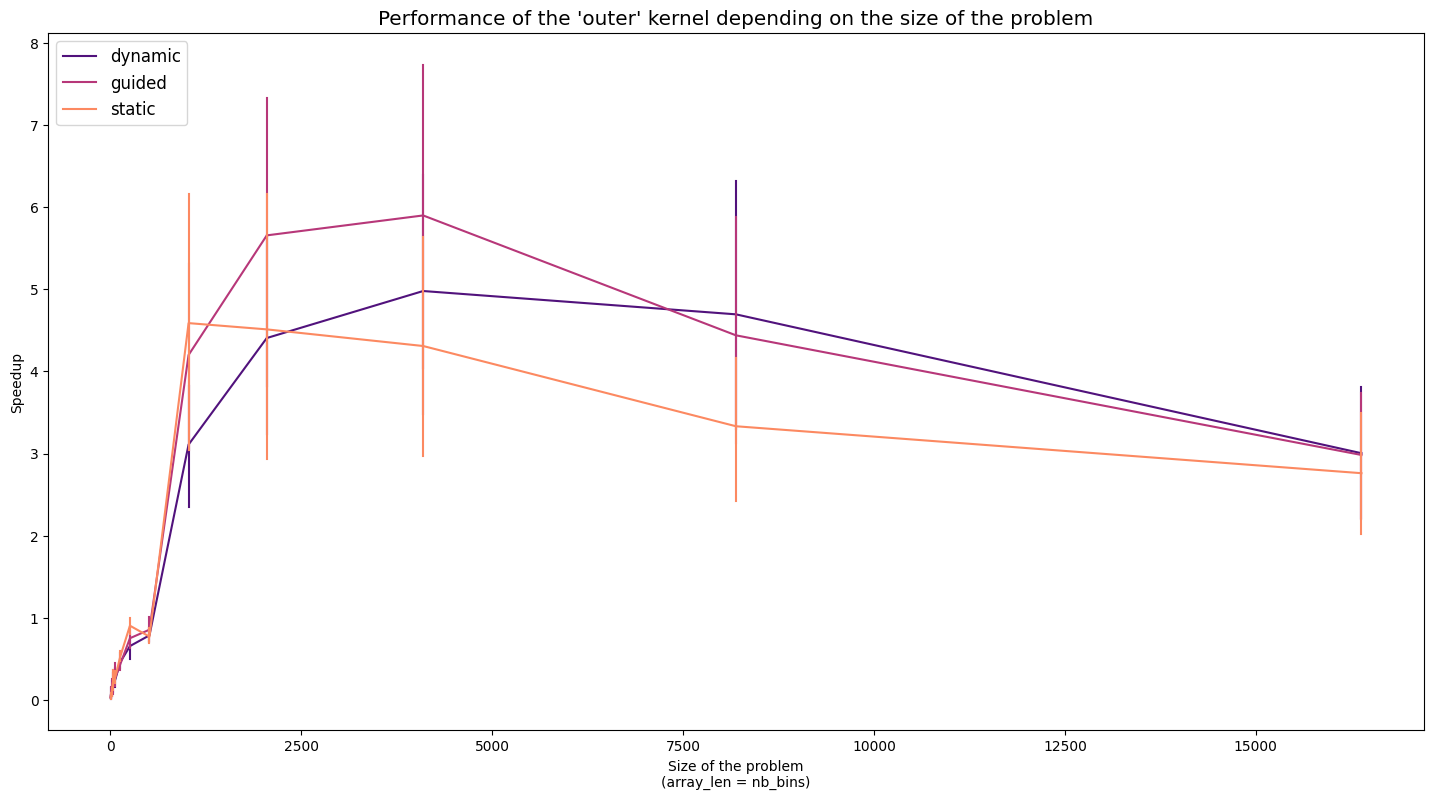

In [10]:
fig, ax = plt.subplots(figsize=(14.5,8))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df_outer, x="size", y="speedup", hue="schedule", markers='o', err_style='bars', palette="magma")
plt.legend(loc='upper left')
plt.title("Performance of the 'outer' kernel depending on the size of the problem")
plt.tight_layout()
plt.xlabel('Size of the problem\n(array_len = nb_bins)')
plt.ylabel('Speedup')
plt.savefig("../plots/histogram_omp/schedule_outer.png", format='png')
plt.show()

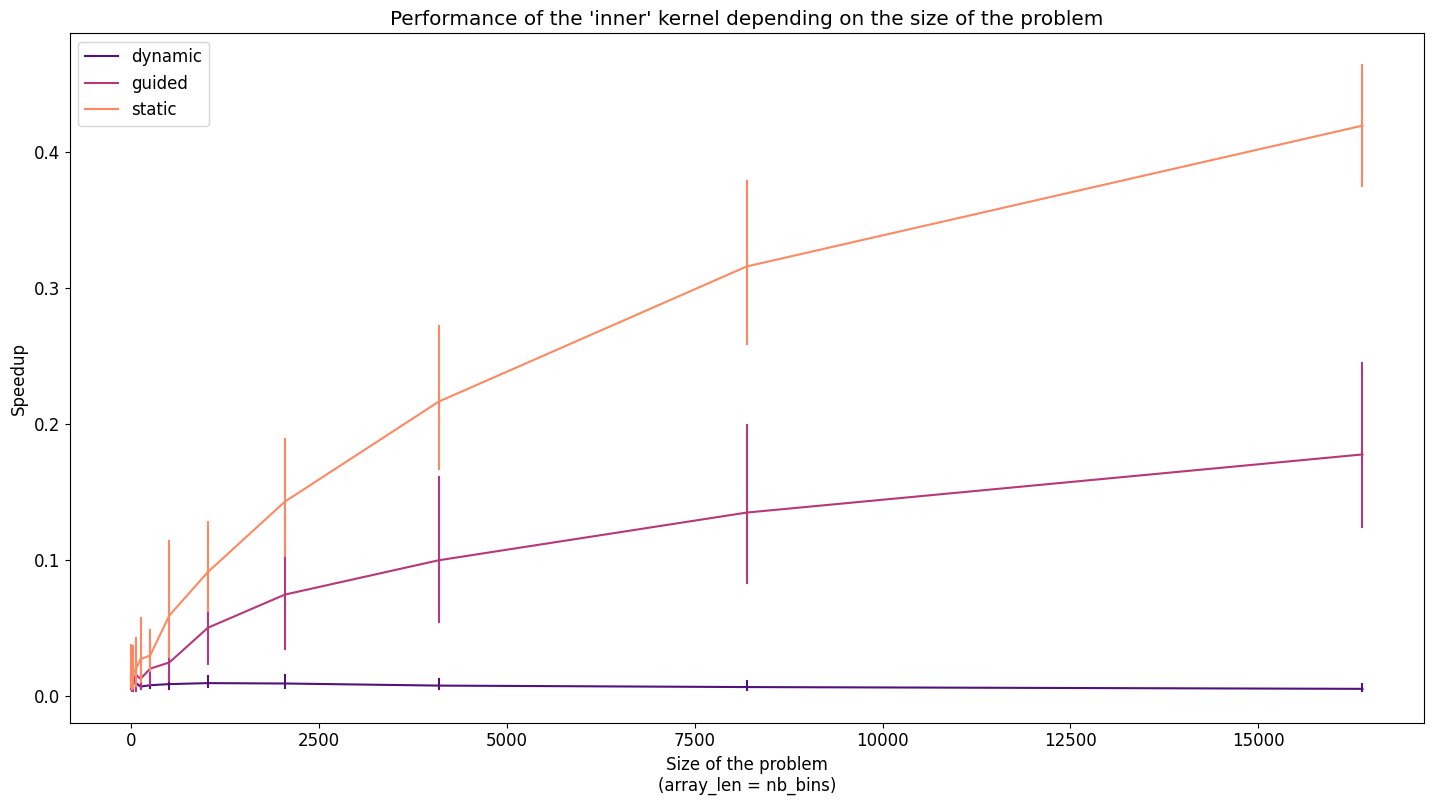

In [11]:
fig, ax = plt.subplots(figsize=(14.5,8))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df_inner, x="size", y="speedup", hue="schedule", markers='o', err_style='bars', palette="magma")
plt.legend(loc='upper left')
plt.title("Performance of the 'inner' kernel depending on the size of the problem")
plt.tight_layout()
plt.xlabel('Size of the problem\n(array_len = nb_bins)')
plt.ylabel('Speedup')
plt.savefig("../plots/histogram_omp/schedule_inner.png", format='png')
plt.show()

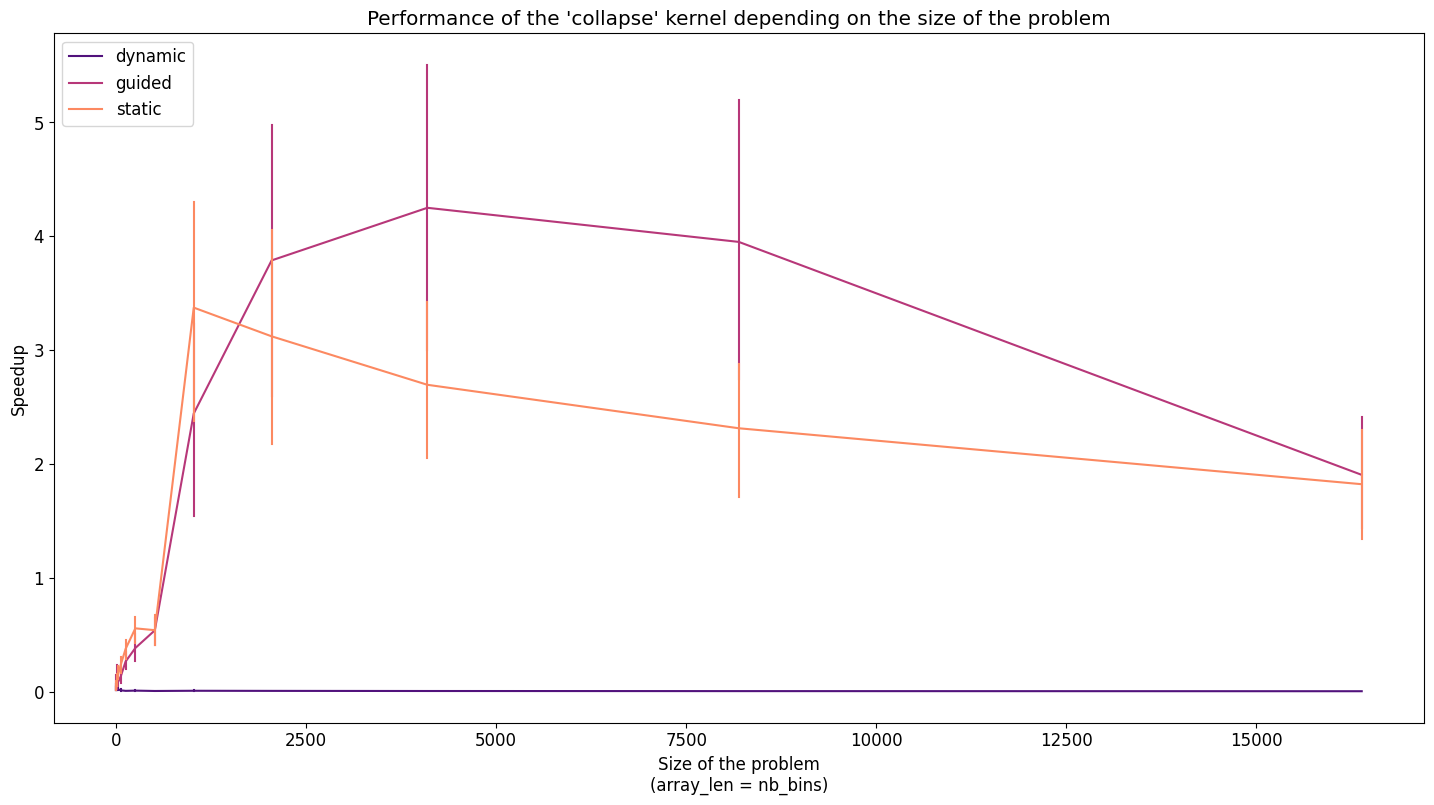

In [12]:
fig, ax = plt.subplots(figsize=(14.5,8))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df_collapse, x="size", y="speedup", hue="schedule", markers='o', err_style='bars', palette="magma")
plt.legend(loc='upper left')
plt.title("Performance of the 'collapse' kernel depending on the size of the problem")
plt.tight_layout()
plt.xlabel('Size of the problem\n(array_len = nb_bins)')
plt.ylabel('Speedup')
plt.savefig("../plots/histogram_omp/schedule_collapse.png", format='png')
plt.show()

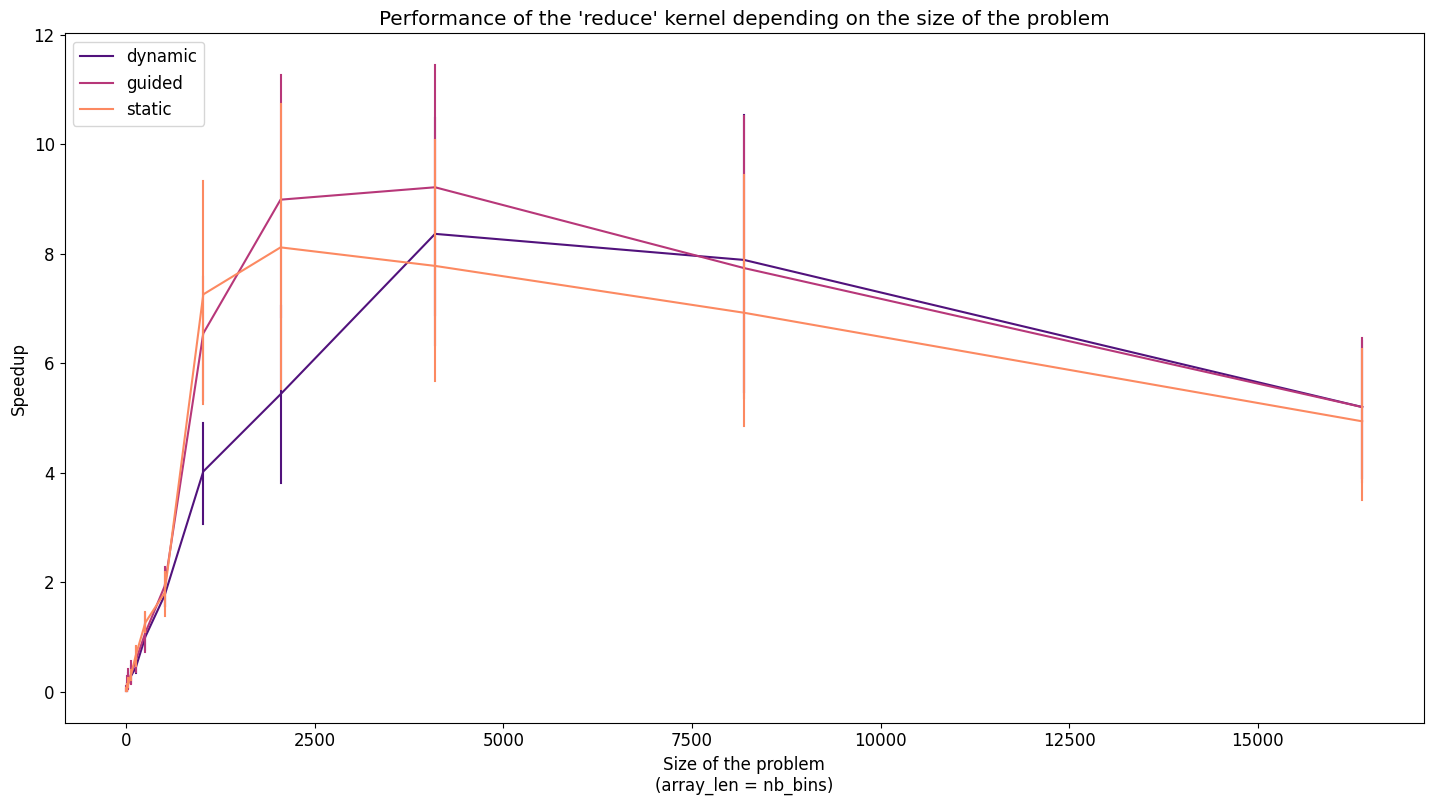

In [13]:
fig, ax = plt.subplots(figsize=(14.5,8))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df_reduce, x="size", y="speedup", hue="schedule", markers='o', err_style='bars', palette="magma")
plt.legend(loc='upper left')
plt.title("Performance of the 'reduce' kernel depending on the size of the problem")
plt.tight_layout()
plt.xlabel('Size of the problem\n(array_len = nb_bins)')
plt.ylabel('Speedup')
plt.savefig("../plots/histogram_omp/schedule_reduce.png", format='png')
plt.show()

In [14]:
frames = [df_outer.loc[df_outer['schedule'] == 'guided'],\
          df_inner.loc[df_inner['schedule'] == 'static'],\
          df_collapse.loc[df_collapse['schedule'] == 'guided'],\
          df_reduce.loc[df_reduce['schedule'] == 'guided']]

df_top = pd.concat(frames)

df_top['kernel'] = df_top['kernel'].replace({'histogram_omp_outer': 'histogram_omp_outer_guided'})
df_top['kernel'] = df_top['kernel'].replace({'histogram_omp_inner': 'histogram_omp_inner_static'})
df_top['kernel'] = df_top['kernel'].replace({'histogram_omp_collapse': 'histogram_omp_collapse_guided'})
df_top['kernel'] = df_top['kernel'].replace({'histogram_omp_reduce': 'histogram_omp_reduce_guided'})

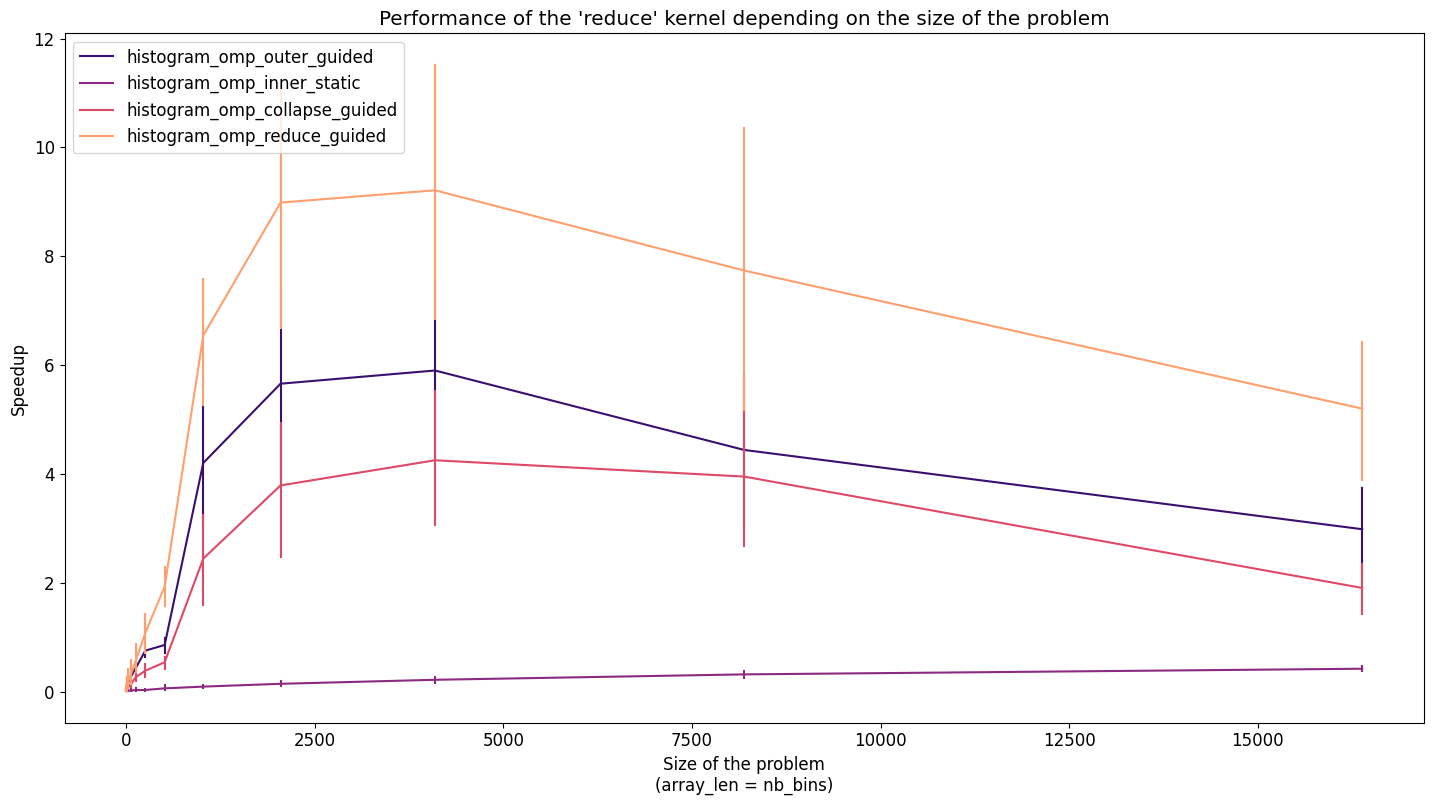

In [15]:
fig, ax = plt.subplots(figsize=(14.5,8))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df_top, x="size", y="speedup", hue="kernel", markers='o', err_style='bars', palette="magma")
plt.legend(loc='upper left')
plt.title("Performance of the 'reduce' kernel depending on the size of the problem")
plt.tight_layout()
plt.xlabel('Size of the problem\n(array_len = nb_bins)')
plt.ylabel('Speedup')
plt.savefig("../plots/histogram_omp/kernel_top.png", format='png')
plt.show()

In [16]:
df_reduce_guided = df_reduce.loc[df_reduce['schedule'] == 'guided'].replace({'histogram_omp_reduce': 'histogram_omp_reduce_guided'});df_reduce_guided

,kernel,threads,schedule,size,timing,timing_ref,speedup
1534,histogram_omp_reduce_guided,1,guided,4,6.875000e-07,2.965000e-07,0.431273
1535,histogram_omp_reduce_guided,1,guided,8,8.105000e-07,5.070000e-07,0.625540
1536,histogram_omp_reduce_guided,1,guided,16,1.041000e-06,1.057000e-06,1.015370
1537,histogram_omp_reduce_guided,1,guided,32,1.639500e-06,2.387000e-06,1.455932
1538,histogram_omp_reduce_guided,1,guided,64,3.323000e-06,5.658500e-06,1.702829
...,...,...,...,...,...,...,...
2010,histogram_omp_reduce_guided,24,guided,1024,9.764450e-05,7.829220e-04,8.018086
2011,histogram_omp_reduce_guided,24,guided,2048,1.638680e-04,2.505749e-03,15.291265
2012,histogram_omp_reduce_guided,24,guided,4096,5.232655e-04,8.086631e-03,15.454163
2013,histogram_omp_reduce_guided,24,guided,8192,4.561100e-03,2.706311e-02,5.933463


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


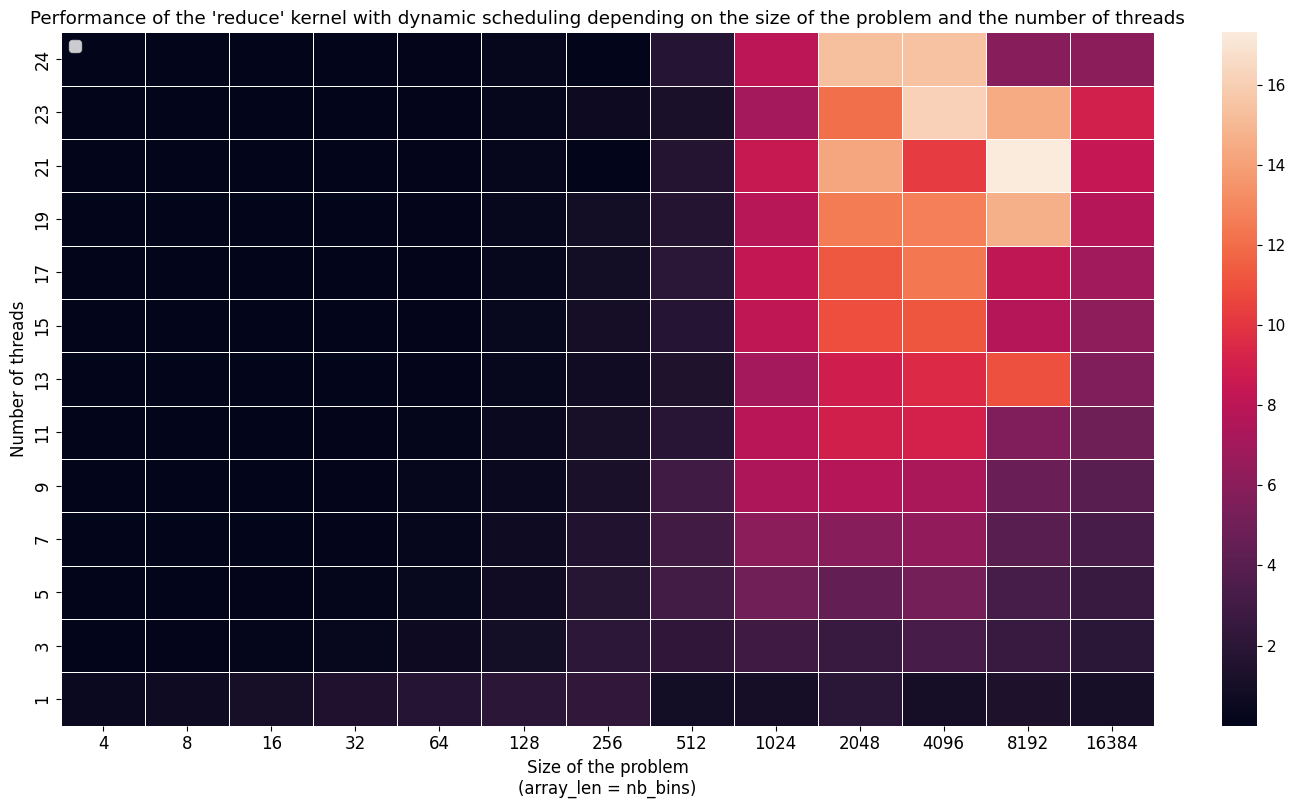

In [17]:
heatmap = pd.pivot_table(df_reduce_guided, values='speedup', index='threads', columns=['size']);heatmap
fig, ax = plt.subplots(figsize=(14.5,8))
plt.rcParams.update({'font.size': 11})
sns.heatmap(heatmap, annot=False, linewidths=.5, ax=ax)
plt.legend(loc='upper left')
plt.title("Performance of the 'reduce' kernel with dynamic scheduling depending on the size of the problem and the number of threads")
plt.tight_layout()
ax.invert_yaxis()
# plt.xscale('log')
plt.xlabel('Size of the problem\n(array_len = nb_bins)')
plt.ylabel('Number of threads')
plt.savefig("../plots/histogram_omp/top_threads.png", format='png')
plt.show()